# Data Preparation Step

* Import the needed libraries

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

* Load dataset from a CSV file

In [60]:
def load_data(file_path):
    return pd.read_csv(file_path)

* Split the dataset into features (X) and target (y)

In [61]:
def split_features_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

* Split dataset into training, validation, and test sets while maintaining class distribution

In [62]:
def split_train_validation_test(X, y, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_size), stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

* Print class distributions for training, validation, and test sets

In [63]:
def print_class_distribution(y_train, y_val, y_test):
    print("Training Class Distribution:\n", y_train.value_counts(normalize=True))
    print("Validation Class Distribution:\n", y_val.value_counts(normalize=True))
    print("Test Class Distribution:\n", y_test.value_counts(normalize=True))

* Perform one-hot encoding for categorical columns

In [64]:
def encode_categorical_columns(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns, dtype='uint8')

* Standardize numerical features using StandardScaler

In [65]:
def standardize_features(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

* Main

Training Class Distribution:
 HeartDisease
1    0.55296
0    0.44704
Name: proportion, dtype: float64
Validation Class Distribution:
 HeartDisease
1    0.554348
0    0.445652
Name: proportion, dtype: float64
Test Class Distribution:
 HeartDisease
1    0.554348
0    0.445652
Name: proportion, dtype: float64
Best_K_According_to_Validation: 13
Best_Accuracy: 0.75

Test_Accuracy: 0.7228260869565217
f1_score: 0.7487684729064039

[[57 25]
 [26 76]]


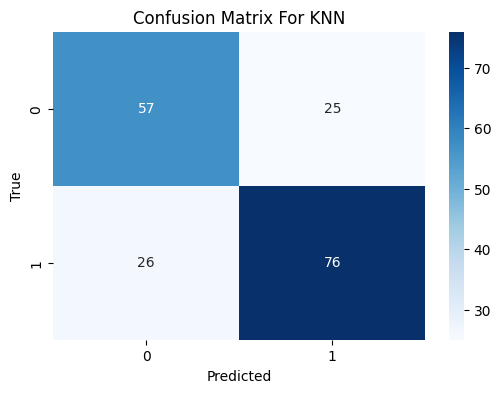

Most Confusing Classes: True label 1 → Predicted as 0


In [72]:
def main():
    # Load dataset
    df = load_data("heart.csv")
    #print(df.head())
    
    # Split features and target
    X, y = split_features_target(df, 'HeartDisease')
    
    # Define categorical columns to encode
    categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    df_encoded = encode_categorical_columns(X, categorical_columns)
    # print("Encoded Columns:", df_encoded.columns)

    # Split data into train, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_validation_test(df_encoded, y)
    
    # Validate class distribution
    print_class_distribution(y_train, y_val, y_test)
        
    # if needed, Standardize dataset
    # df_standardized = standardize_features(df_encoded)
    # print(df_standardized.head())
    classify_knn(X_train, X_val, X_test, y_train, y_val, y_test)

if __name__ == "__main__":
    main()

# KNN Classifier

* Import the needed libraries

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

* Train the KNN model on X_train, y_train and hyperparameter k

In [67]:
def train_knn_model(n_neighbors, X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    return knn

* Validate the KNN model using X_val, y_val and the trained model

In [68]:
def validate_knn_model(knn, X_val, y_val):
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val,y_pred)
    return accuracy

* Evaluate the KNN model using X_test, y_test and calculate the accuracy, f1_score and confusion matrix

In [69]:
def eval_knn_model(knn, X_test, y_test):
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, f_score, conf_matrix

* Plot the confusion matrix as heatMap

In [70]:
def plot(conf_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix For KNN')
    plt.show()

* Classify

In [ ]:
def classify_knn(X_train, X_val, X_test, y_train, y_val, y_test):
    best_k = 1
    best_accuracy = 0
    
    for k in range(1, 31):
        knn = train_knn_model(k, X_train, y_train)
        accuracy = validate_knn_model(knn, X_val, y_val)
        if(accuracy > best_accuracy):
            best_accuracy = accuracy
            best_k = k

    print(f"Best_K_According_to_Validation: {best_k}")
    print(f"Best_Accuracy: {best_accuracy}\n")
    
    best_knn = train_knn_model(best_k, X_train, y_train)
    test_accuracy, f_score, conf_matrix = eval_knn_model(best_knn, X_test, y_test)
    
    print(f"Test_Accuracy: {test_accuracy}")
    print(f"f1_score: {f_score}\n")

    plot(conf_matrix)
    most_confusing = np.unravel_index(np.argmax(conf_matrix - np.diag(np.diag(conf_matrix))), conf_matrix.shape)
    print(f"Most Confusing Classes: True label {most_confusing[0]} → Predicted as {most_confusing[1]}")
